# [Lab Session 4](deconvolution.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

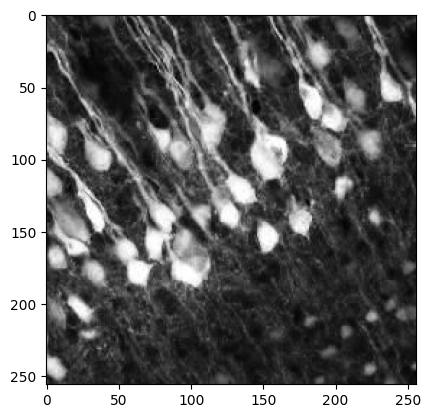

In [2]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [3]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2

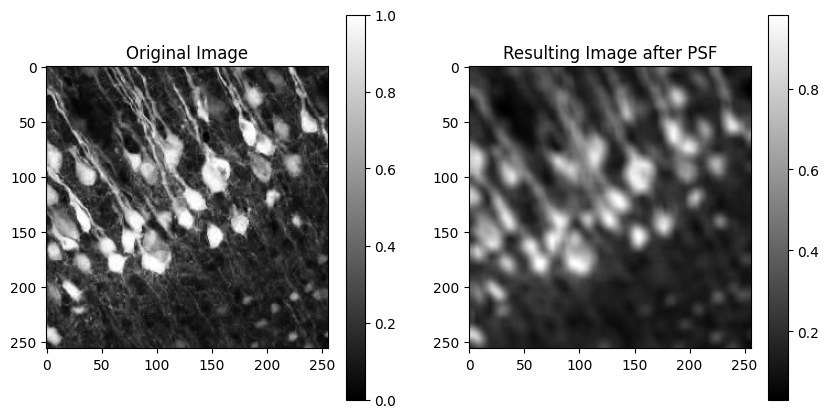

In [4]:
# Convolution
result_img = conv(img, psf, mode='same', boundary='symm')

# Vizualisation 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(result_img, cmap='gray')
plt.title("Resulting Image after PSF")
plt.colorbar()

plt.show()

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

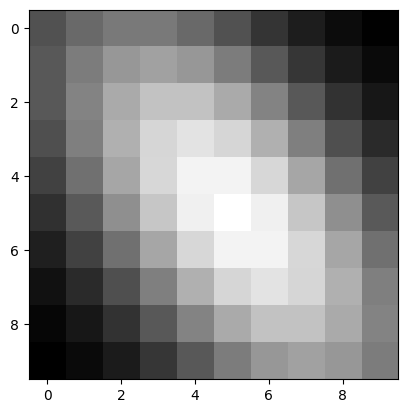

In [5]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

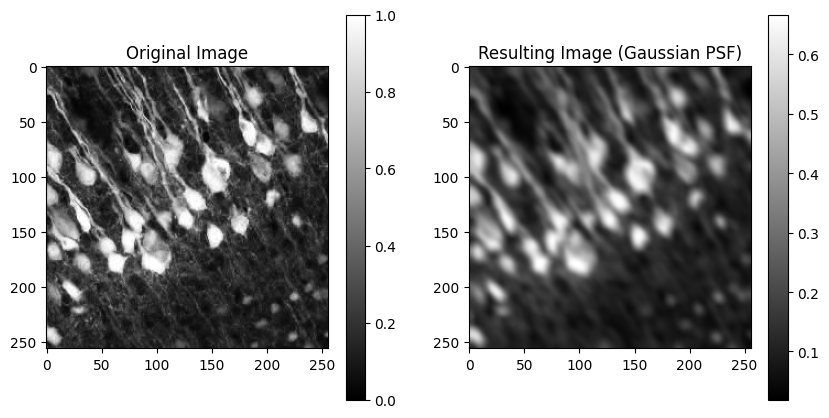

In [6]:
# gaussian psf
gaussian_psf = create_psf(psf_size)

# Convolution with gaussian psv
result_img_gaussian = conv(img, gaussian_psf, mode='same', boundary='symm')

# Comparison of both psvs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(result_img_gaussian, cmap='gray')
plt.title("Resulting Image (Gaussian PSF)")
plt.colorbar()

plt.show()

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [7]:
def richardson_lucy(g, psf, iterations=35):
    # Initialisiere h mit konstantem Wert 0.5
    h = np.full(g.shape, 0.5)
    
    # Flip die PSF (P*)
    psf_flipped = np.flip(psf)
    
    # Iterationen des Richardson-Lucy Algorithmus
    for _ in range(iterations):
        # Schritt 1: h(t) * P
        conv_h_p = conv(h, psf, mode='same', boundary='symm')
        
        # Schritt 2: Division g / (h(t) * P)
        relative_blur = g / (conv_h_p + 1e-10)  # Plus die kleine Zahl, sodass eine Division durch 0 vermieden wird 
        
        # Schritt 3: (g / (h(t) * P)) * P*
        correction = conv(relative_blur, psf_flipped, mode='same', boundary='symm')
        
        # Schritt 4: Update h(t+1) = h(t) * correction
        h *= correction
    
    return h

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

In [8]:
rl_blurred = richardson_lucy(result_img, psf)

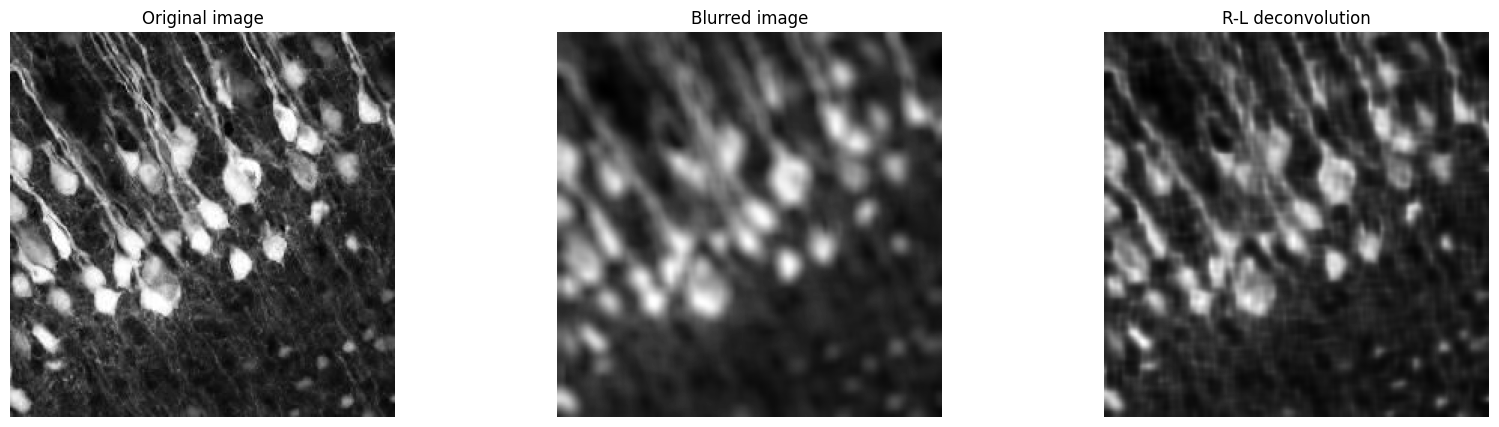

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')

plt.imshow(result_img, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')

plt.imshow(rl_blurred, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [17]:
noise = (np.random.normal(loc=5,size=img.shape))
reduce_factor = 50
noise = noise / reduce_factor

noisy_img = result_img_gaussian + noise
noisy_img = np.clip(noisy_img, 0, 1)

In [18]:
deconvolved_noisy = richardson_lucy(noisy_img, psf, iterations=20)

Text(0.5, 1.0, 'Deconvolved Noisy Image')

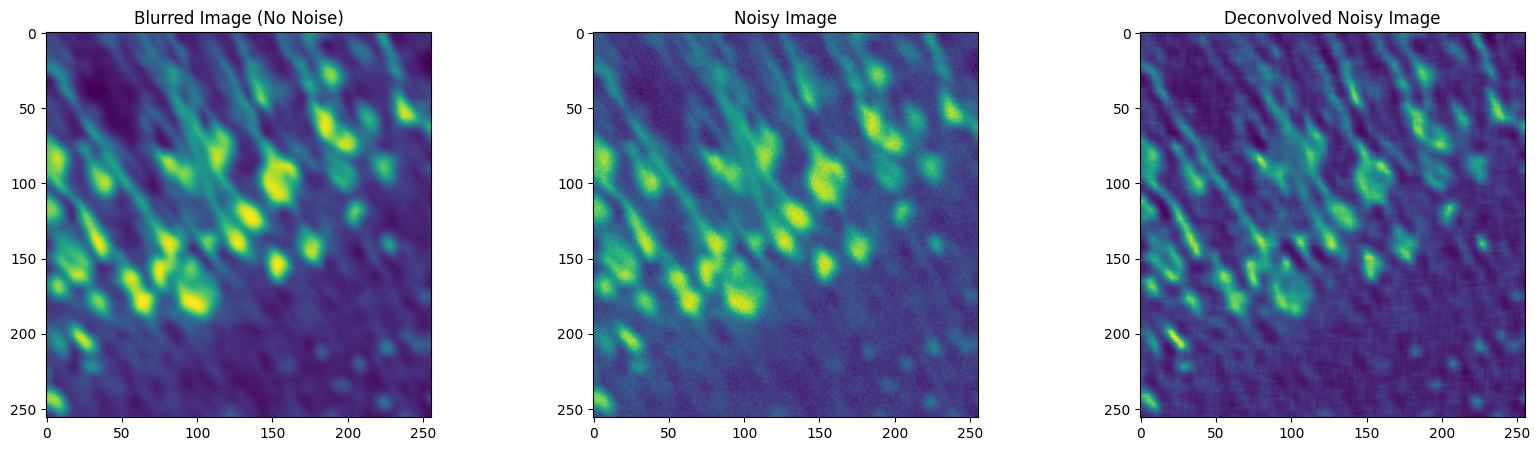

In [19]:
# Originalbild 
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.imshow(result_img_gaussian)
plt.title("Blurred Image (No Noise)")

# Verrauschtes Bild
plt.subplot(1, 3, 2)
plt.imshow(noisy_img)
plt.title("Noisy Image")

# Dekonvolviertes verrauschtes Bild
plt.subplot(1, 3, 3)
plt.imshow(deconvolved_noisy)
plt.title("Deconvolved Noisy Image")


**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

In [13]:
wiener_img = wiener(result_img, psf, balance=2, clip=True)


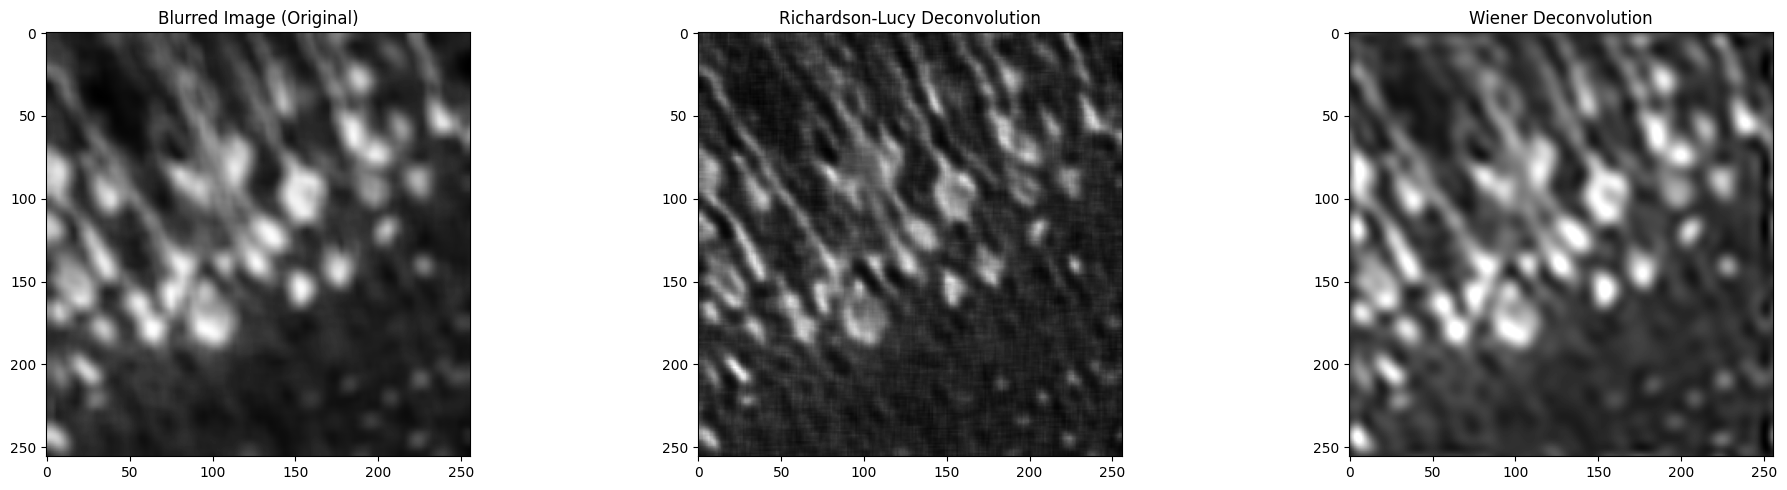

In [21]:
# Originalbild (unscharf)
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.imshow(result_img, cmap='gray')
plt.title("Blurred Image (Original)")

# Richardson-Lucy Ergebnis
plt.subplot(1, 3, 2)
plt.imshow(deconvolved_noisy, cmap='gray')
plt.title("Richardson-Lucy Deconvolution")

# Wiener Ergebnis
plt.subplot(1, 3, 3)
plt.imshow(wiener_img, cmap='gray')
plt.title("Wiener Deconvolution")

plt.tight_layout()
plt.show()

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

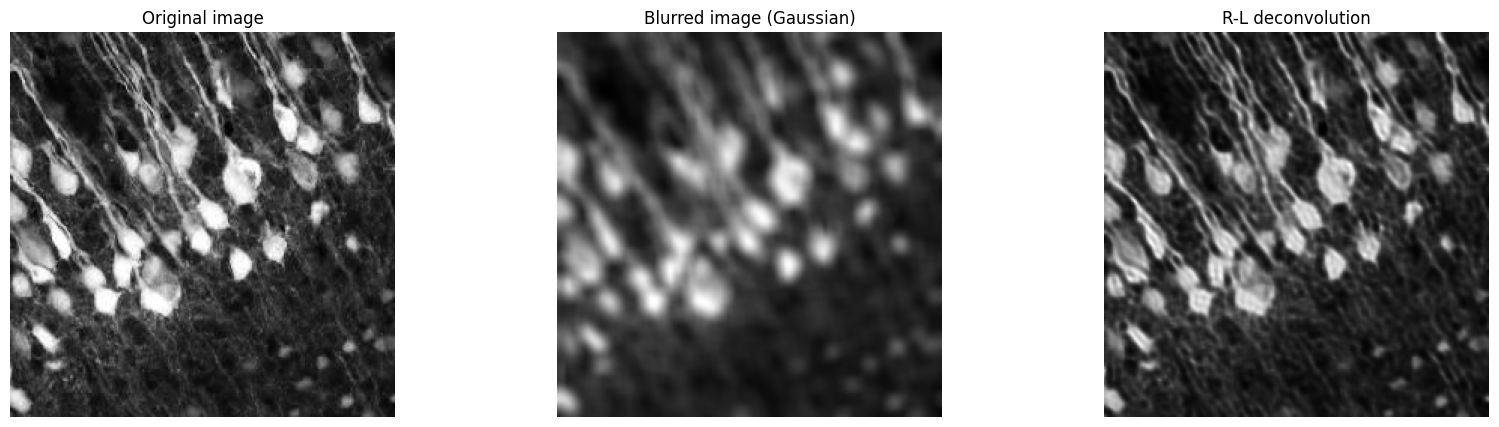

In [25]:
# Defining a new psf
psf_size = 5
psf = np.ones((psf_size, psf_size)) / psf_size ** 2

# Gaussian psf wirh the new psf
gaussian_psf = create_psf(psf_size)

# Convolution with gaussian psv
result_img_gaussian = conv(img, gaussian_psf, mode='same', boundary='symm')

# Deconvolution 
rl_blurred = richardson_lucy(result_img_gaussian, psf)

# Vizualisation 
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')

plt.imshow(result_img, 'gray')
plt.title('Blurred image (Gaussian)')
plt.subplot(1, 3, 3)
plt.axis('off')

plt.imshow(rl_blurred, 'gray')
plt.title('R-L deconvolution')
plt.show()


Text(0.5, 1.0, 'Deconvolved Noisy Image, psf = 5')

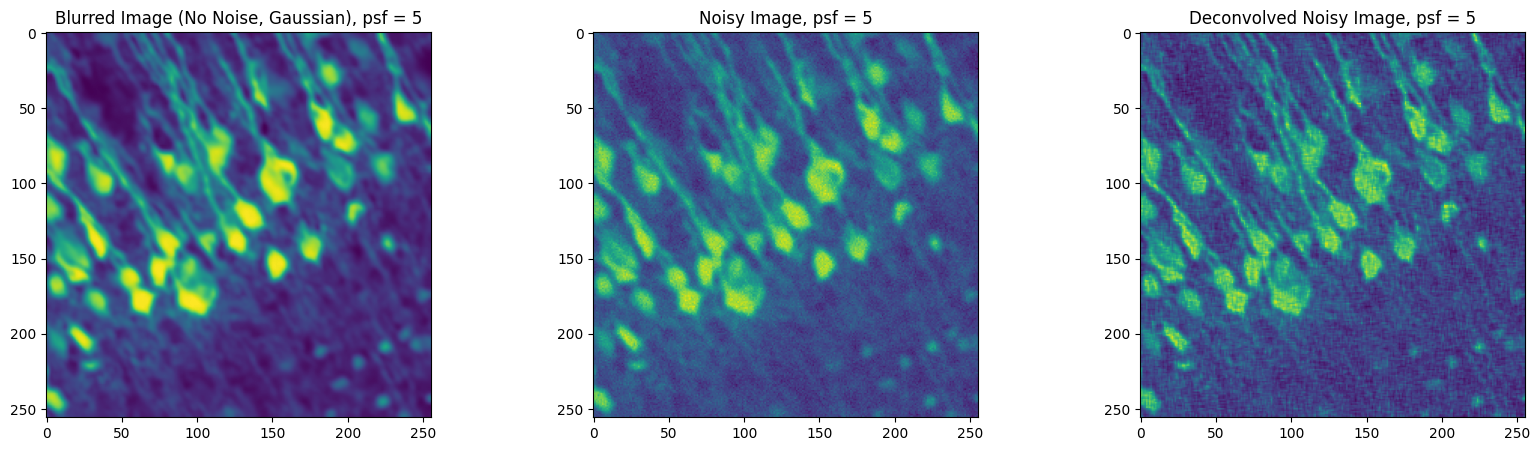

In [27]:
# Adding the noise
noise = (np.random.normal(loc=5,size=img.shape))
reduce_factor = 50
noise = noise / reduce_factor

noisy_img = result_img_gaussian + noise
noisy_img = np.clip(noisy_img, 0, 1)

deconvolved_noisy = richardson_lucy(noisy_img, psf, iterations=20)

# Vizualisation  
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.imshow(result_img_gaussian)
plt.title("Blurred Image (No Noise, Gaussian), psf = 5")

plt.subplot(1, 3, 2)
plt.imshow(noisy_img)
plt.title("Noisy Image, psf = 5")

plt.subplot(1, 3, 3)
plt.imshow(deconvolved_noisy)
plt.title("Deconvolved Noisy Image, psf = 5")


**[Task 8.]()** Use a wrong PSF to restore the image

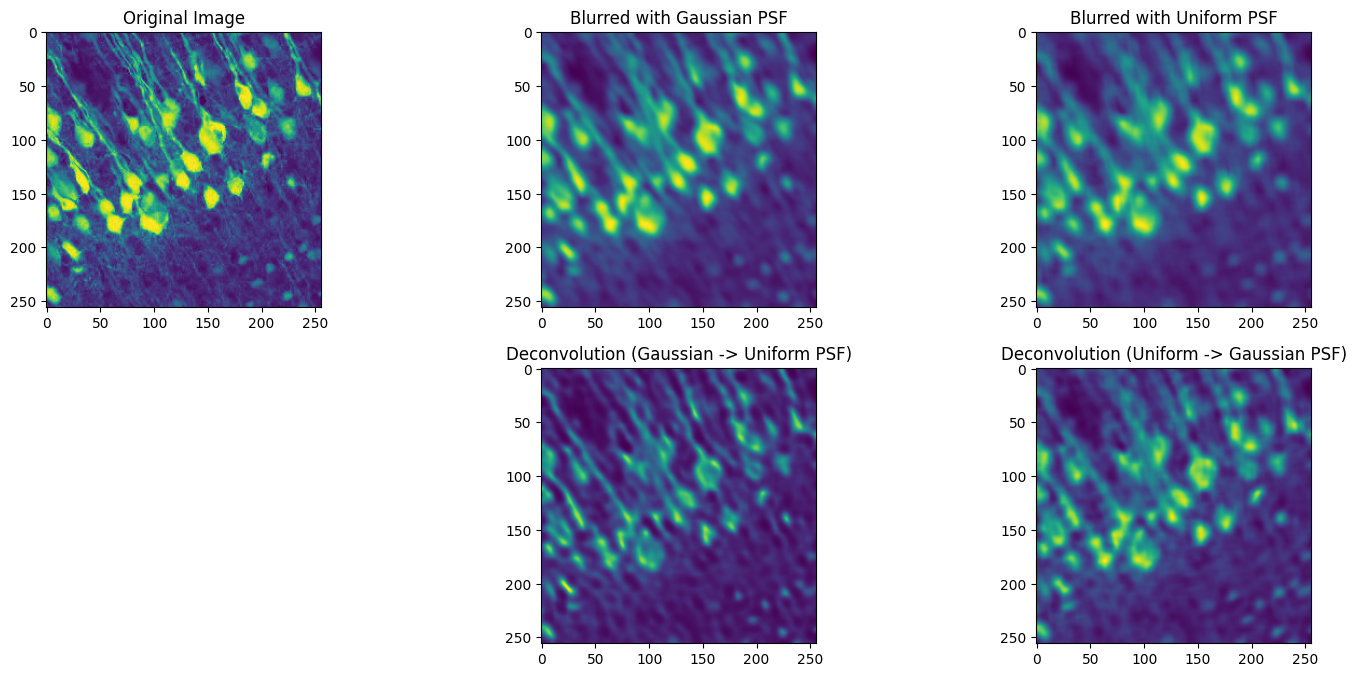

In [31]:
psf_uniform = np.ones((10, 10)) / 100  # Uniform PSF
psf_gaussian = create_psf(10)          # Gaussian PSF (vorher definiert)


# Unscharfe Bilder erzeugen
blurred_gaussian = conv(img, psf_gaussian, mode='same', boundary='symm')
blurred_uniform = conv(img, psf_uniform, mode='same', boundary='symm')

# Dekonvolution mit falscher PSF
deconvolved_gaussian_with_uniform = richardson_lucy(blurred_gaussian, psf_uniform, iterations=20)
deconvolved_uniform_with_gaussian = richardson_lucy(blurred_uniform, psf_gaussian, iterations=20)

# Ergebnisse visualisieren
plt.figure(figsize=(15, 10))

# Originalbild
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title("Original Image")

# Gaussian Blur
plt.subplot(3, 3, 2)
plt.imshow(blurred_gaussian)
plt.title("Blurred with Gaussian PSF")

# Uniform Blur
plt.subplot(3, 3, 3)
plt.imshow(blurred_uniform)
plt.title("Blurred with Uniform PSF")

# Dekonvolution: Gaussian Blur mit Uniform PSF
plt.subplot(3, 3, 5)
plt.imshow(deconvolved_gaussian_with_uniform)
plt.title("Deconvolution (Gaussian -> Uniform PSF)")

# Dekonvolution: Uniform Blur mit Gaussian PSF
plt.subplot(3, 3, 6)
plt.imshow(deconvolved_uniform_with_gaussian)
plt.title("Deconvolution (Uniform -> Gaussian PSF)")

plt.tight_layout()
plt.show()